<a href="https://colab.research.google.com/github/rajeshgayathri2003/EVPR/blob/main/EVRP_RL_Qlearning_siouxfalls_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries


Ref:
1.  https://github.com/marsuconn/sioux-falls-network/tree/master
2. https://github.com/bstabler/TransportationNetworks
3. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9792244
4. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=10695073



In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import gym
from gym import spaces
import networkx as nx
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import os
import pandas as pd
pd.options.display.float_format = "{:,.2f}".format  # Display only 2 decimal points

## Create Graph network


In [ ]:
net= pd.read_csv('/content/SiouxFalls_net.tntp', skiprows=8, sep='\t').drop(['~', ';'], axis =1)
net['edge']=net.index+1
flow=pd.read_csv('/content/SiouxFalls_flow.tntp',sep='\t').drop(['From ', 'To '],axis=1)
flow.rename(columns={"Volume ": "flow", "Cost ": "cost"},inplace=True)
node_coord=pd.read_csv('/content/SiouxFalls_node.tntp',sep='\t').drop([';'], axis=1) # Actual Sioux Falls coordinate
node_xy=pd.read_csv('/content/SiouxFalls_node_xy.tntp',sep='\t') # X,Y position for good visualization

In [ ]:
# dataframe containing all link attributes
sioux_falls_df=pd.concat([net,flow], axis=1)
sioux_falls_df

,init_node,term_node,capacity,length,free_flow_time,b,power,speed,toll,link_type,edge,flow,cost
0,1,2,"25,900.20",6,6,0.15,4,0,0,1,1,"4,494.66",6.00
1,1,3,"23,403.47",4,4,0.15,4,0,0,1,2,"8,119.08",4.01
2,2,1,"25,900.20",6,6,0.15,4,0,0,1,3,"4,519.08",6.00
3,2,6,"4,958.18",5,5,0.15,4,0,0,1,4,"5,967.34",6.57
4,3,1,"23,403.47",4,4,0.15,4,0,0,1,5,"8,094.66",4.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,23,22,"5,000.00",4,4,0.15,4,0,0,1,72,"9,626.21",12.24
72,23,24,"5,078.51",2,2,0.15,4,0,0,1,73,"7,902.98",3.76
73,24,13,"5,091.26",4,4,0.15,4,0,0,1,74,"11,112.39",17.62
74,24,21,"4,885.36",3,3,0.15,4,0,0,1,75,"10,259.52",11.75


In [ ]:
sioux_falls_df['length'] *= 5
print("Updated DataFrame:")
print(sioux_falls_df)

Updated DataFrame:
    init_node  term_node  capacity  length  free_flow_time    b  power  speed  \
0           1          2 25,900.20      30               6 0.15      4      0   
1           1          3 23,403.47      20               4 0.15      4      0   
2           2          1 25,900.20      30               6 0.15      4      0   
3           2          6  4,958.18      25               5 0.15      4      0   
4           3          1 23,403.47      20               4 0.15      4      0   
..        ...        ...       ...     ...             ...  ...    ...    ...   
71         23         22  5,000.00      20               4 0.15      4      0   
72         23         24  5,078.51      10               2 0.15      4      0   
73         24         13  5,091.26      20               4 0.15      4      0   
74         24         21  4,885.36      15               3 0.15      4      0   
75         24         23  5,078.51      10               2 0.15      4      0   

    toll

In [ ]:
def create_graph(sioux_falls_df):
    # Create graph

    G = nx.from_pandas_edgelist(sioux_falls_df, 'init_node', 'term_node',
                                 ['capacity', 'length', 'free_flow_time', 'b', 'power', 'speed',
                                  'toll', 'link_type', 'edge', 'flow', 'cost'],
                                 create_using=nx.MultiDiGraph())

    # Coordinate positions
    pos_coord = {i: (a, b) for i, a, b in zip(node_coord.Node, node_coord.X, node_coord.Y)}
    pos_xy = {i: (a, b) for i, a, b in zip(node_xy.Node, node_xy.X, node_xy.Y)}

    # Assign positions as attributes
    for n, p in pos_coord.items():
        G.nodes[n]['pos_coord'] = p

    for n, p in pos_xy.items():
        G.nodes[n]['pos_xy'] = p

    # Define charging stations
    charging_stations = {2, 6, 12, 16}
    for n in G.nodes:
        G.nodes[n]['charging_station'] = n in charging_stations

    return G, pos_xy, charging_stations

In [ ]:
def plot_graph(G, pos):
    plt.figure(figsize=(12, 12))

    # Define node colors
    node_colors = ['red' if G.nodes[n]['charging_station'] else 'blue' for n in G.nodes]

    # Draw graph
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200)
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.legend(loc='upper right', fontsize=12)
    plt.title('Sioux Falls Network with Charging Stations', fontsize=20)

    # Save figure
    plt.savefig('sioux-falls-network.png')
    plt.show()

In [ ]:
def find_all_paths(graph, start_state, goal_state):
    paths = list(nx.all_simple_paths(graph, source=start_state, target=goal_state))
    path_distances = []
    for idx, path in enumerate(paths, start=1):
        distance = sum(graph[path[i]][path[i + 1]][0]['length'] for i in range(len(path) - 1) if graph[path[i]][path[i + 1]])
        path_distances.append((idx, path, distance))
    return path_distances

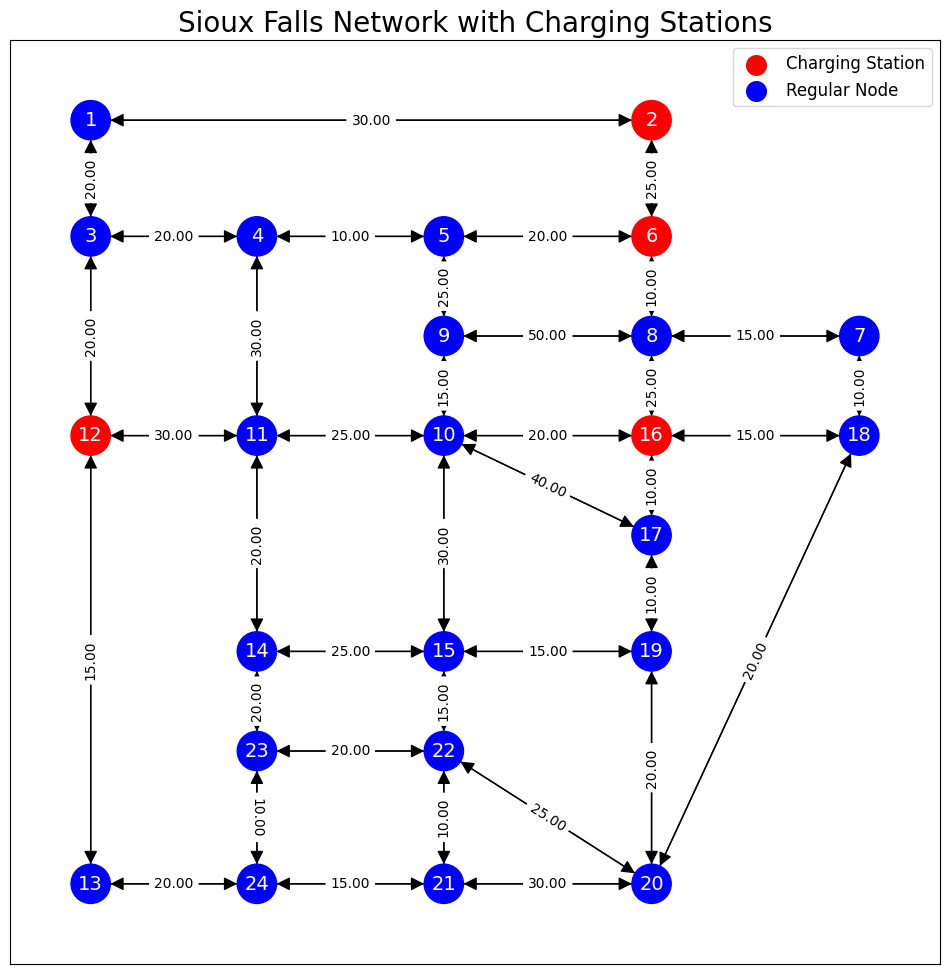

In [ ]:
# Execution
G, pos,charging_stations = create_graph(sioux_falls_df)
plot_graph(G, pos)

In [ ]:
all_paths = find_all_paths(G, start_state=1, goal_state=24)
print("\nAll paths from node 1 to 24 and their distances:")
for idx, path, distance in all_paths:
    print(f"Path {idx}: {path}, Distance: {distance:.2f}")


All paths from node 1 to 24 and their distances:
Path 1: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 14, 23, 22, 20, 21, 24], Distance: 455.00
Path 2: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 14, 23, 22, 21, 24], Distance: 410.00
Path 3: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 14, 23, 24], Distance: 375.00
Path 4: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 22, 20, 21, 24], Distance: 405.00
Path 5: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 22, 21, 24], Distance: 360.00
Path 6: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 15, 22, 23, 24], Distance: 365.00
Path 7: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 20, 21, 22, 15, 14, 23, 24], Distance: 435.00
Path 8: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 20, 21, 22, 23, 24], Distance: 395.00
Path 9: [1, 2, 6, 5, 4, 3, 12, 11, 10, 9, 8, 7, 18, 16, 17, 19, 20, 21, 24], Distance: 370.00
Path 10: [1, 2, 6, 5, 4, 3, 12, 

##RL Implementation

In [ ]:
# Create a graph with nodes, edges, and charging stations
G, locations, charging_stations = create_graph(sioux_falls_df)

# Hyperparameters for the Q-learning algorithm
alpha = 0.1  # Learning rate
gamma = 0.9  # Discount factor
epsilon = 1.0  # Exploration rate (initially set to 1 for maximum exploration)
epsilon_decay = 0.995  # Decay rate for epsilon (reduces exploration over time)
epsilon_min = 0.01  # Minimum value for epsilon (ensures some exploration)
num_episodes = 1000  # Number of episodes for training
max_steps_per_episode = 100  # Maximum steps allowed per episode

# Constants for the simulation
average_velocity = 45  # Average speed of the vehicle in km/h
initial_SoC = 50 # Initial State of Charge (SoC) of the battery
SoC_consumption_rate = 0.5 # Rate at which the battery is consumed per km
charging_capacity = 50  # Amount of charge added at a charging station
max_cap = 90  # Maximum battery capacity

# Properties of charging stations (station ID: (charging time, waiting time))
charging_station_properties = {
    2: (30, 10) , 6: (35, 15),
    12: (20, 10), 16: (30, 5)
}

# Mapping of charging station IDs to indices for Q-table access
charging_station_index = {station: idx for idx, station in enumerate(charging_stations)}
# Map node IDs to zero-based indices
node_to_index = {node: idx for idx, node in enumerate(G.nodes())}


destination_node =24

##Q learning v3

In [ ]:
# Initialize Q-tables
num_states = G.number_of_nodes()
num_actions = G.number_of_nodes()
Q_layer1 = np.zeros((num_states, num_actions))
Q_layer2 = np.zeros((num_states, len(charging_stations)))

def get_state(current_node, SoC):
    return current_node

def choose_action_layer1(state, SoC):
    valid_actions = list(G.neighbors(state))

    # Filter out actions that lead to already visited nodes
    unexplored_actions = [action for action in valid_actions if action not in visited_nodes]

    if unexplored_actions:  # If there are unexplored actions, prioritize them
        valid_actions = unexplored_actions

    if np.random.rand() <= epsilon:
        return random.choice(valid_actions)  # Exploration: choose a random valid action
    else:
        # Exploitation: choose the action with the highest Q-value
        valid_q_values = {action: Q_layer1[node_to_index[state], node_to_index[action]] for action in valid_actions}
        return max(valid_q_values, key=valid_q_values.get)

def choose_action_layer2(state):
    if np.random.rand() <= epsilon:
        return random.choice(list(charging_stations))
    else:
        valid_q_values = {station: Q_layer2[node_to_index[state], charging_station_index[station]] for station in charging_stations}
        return max(valid_q_values, key=valid_q_values.get)

def calculate_travel_time(distance):
    return (distance / average_velocity) * 60

def step_layer1(action, current_node, SoC, visited_nodes, path):
    if G.has_edge(current_node, action):
        edge_key = next(iter(G[current_node][action]))
        distance = G[current_node][action][edge_key]['length']
        travel_time = calculate_travel_time(distance)
        SoC -= distance * SoC_consumption_rate
        total_time = travel_time
        reward = -total_time
        next_node = action
    else:
        reward = -1000  # Heavy penalty for invalid action
        next_node = current_node
        total_time = 0

    # Increased penalty for revisiting nodes
    if next_node in visited_nodes:
        reward -= 500  # Increased penalty for revisiting nodes

    # Add a penalty based on the distance to the destination
    shortest_path_distance = nx.shortest_path_length(G, source=next_node, target=destination_node, weight='length')
    reward -= shortest_path_distance * 0.1

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    return next_node, SoC, reward, total_time

def step_layer2(action, current_node, SoC, path):
    # Calculate the distance to the charging station
    distance_to_station = nx.shortest_path_length(G, source=current_node, target=action, weight='length')

    # Calculate the required SoC to reach the charging station
    required_SoC = distance_to_station * SoC_consumption_rate

    # Check if the current SoC is sufficient to reach the charging station
    if SoC < required_SoC:
        # Impose a heavy penalty if the SoC is insufficient
        reward = -1000  # Heavy penalty for not being able to reach the charging station
        total_time = 0  # No time is spent since the vehicle cannot move
        next_node = current_node  # Stay at the current node
        return next_node, SoC, reward, total_time

    # If the SoC is sufficient, proceed with the original logic
    path_to_station = nx.shortest_path(G, source=current_node, target=action, weight='length')
    path.extend([node for i, node in enumerate(path_to_station[1:]) if i == 0 or path_to_station[i] != node])

    # Calculate the travel time to the charging station
    travel_time = calculate_travel_time(distance_to_station)

    # Get charging time and waiting time from the charging station properties
    charging_time, waiting_time = charging_station_properties[action]

    # Calculate the total time spent (travel + charging + waiting)
    total_time = travel_time + charging_time + waiting_time

    # Update the SoC after charging
    SoC = min(max_cap, SoC + charging_capacity)

    # Calculate the reward (negative of total time)
    reward = -total_time

    # Set the next node to the charging station
    next_node = action

    return next_node, SoC, reward, total_time

episode_rewards = []
for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()  # Track visited nodes
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = get_state(current_node, SoC)
        if SoC <= 30:
            action_layer2 = choose_action_layer2(state)
            next_node, SoC, reward_layer2, time_taken_layer2 = step_layer2(action_layer2, current_node, SoC, path)
            total_time += time_taken_layer2
            action_idx = charging_station_index[action_layer2]
            next_state_layer2 = get_state(next_node, SoC)
            Q_layer2[node_to_index[state], action_idx] += alpha * (reward_layer2 + gamma * np.max(Q_layer2[node_to_index[next_state_layer2]]) - Q_layer2[node_to_index[state], action_idx])
            episode_reward += reward_layer2
        else:
            action_layer1 = choose_action_layer1(state, SoC)
            next_node, SoC, reward_layer1, time_taken_layer1 = step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
            total_time += time_taken_layer1
            next_state_layer1 = get_state(next_node, SoC)
            Q_layer1[node_to_index[state], node_to_index[action_layer1]] += alpha * (reward_layer1 + gamma * np.max(Q_layer1[node_to_index[next_state_layer1]]) - Q_layer1[node_to_index[state], node_to_index[action_layer1]])
            episode_reward += reward_layer1

        # Update visited nodes and current node
        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

    # Decay epsilon for exploration-exploitation trade-off
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(episode_reward)
    print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")


    # Testing the trained model
current_node = 6
destination_node = 24
SoC = initial_SoC
path = [current_node]
total_time = 0
steps = 0
visited_nodes = set()  # Track visited nodes
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = get_state(current_node, SoC)
    if SoC <= 30:
        action_layer2 = choose_action_layer2(state)
        next_node, SoC, _, time_taken_layer2 = step_layer2(action_layer2, current_node, SoC, path)
        total_time += time_taken_layer2
        charging_stations_visited[action_layer2] = time_taken_layer2
    else:
        action_layer1 = choose_action_layer1(state, SoC)
        next_node, SoC, _, time_taken_layer1 = step_layer1(action_layer1, current_node, SoC, visited_nodes, path)
        total_time += time_taken_layer1

    # Additional penalty for staying at the same node
    if next_node == current_node:
        total_time += 10  # Additional penalty for staying at the same node

    # Update the path if the next node is not already the last node in the path
    if not (path and path[-1] == next_node):
        path.append(next_node)

    # Update visited nodes and current node
    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
if charging_stations_visited:
    print("Charging Stations Visited and Time Spent:")
    for station, time_spent in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes")
else:
    print("No Charging Stations Visited.")

Episode: 0, Total Time: 1005.0000000000001, Episode Reward: -6641.5
Episode: 1, Total Time: 486.66666666666663, Episode Reward: -88547.66666666667
Episode: 2, Total Time: 521.6666666666666, Episode Reward: -89128.66666666667
Episode: 3, Total Time: 985.0000000000002, Episode Reward: -8635.499999999998
Episode: 4, Total Time: 183.33333333333331, Episode Reward: -198.33333333333331
Episode: 5, Total Time: 130.0, Episode Reward: -141.0
Episode: 6, Total Time: 426.6666666666667, Episode Reward: -3473.6666666666665
Episode: 7, Total Time: 1881.666666666666, Episode Reward: -20697.166666666668
Episode: 8, Total Time: 183.33333333333331, Episode Reward: -198.33333333333331
Episode: 9, Total Time: 386.6666666666667, Episode Reward: -447.6666666666667
Episode: 10, Total Time: 130.0, Episode Reward: -141.0
Episode: 11, Total Time: 183.33333333333331, Episode Reward: -198.33333333333331
Episode: 12, Total Time: 130.0, Episode Reward: -141.0
Episode: 13, Total Time: 811.6666666666665, Episode Rewa

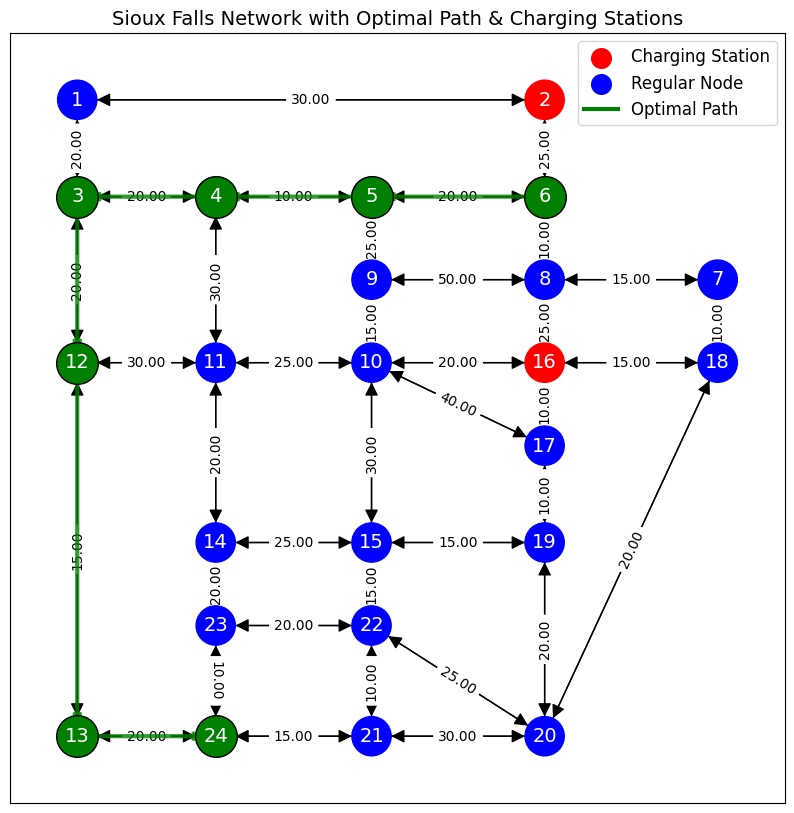

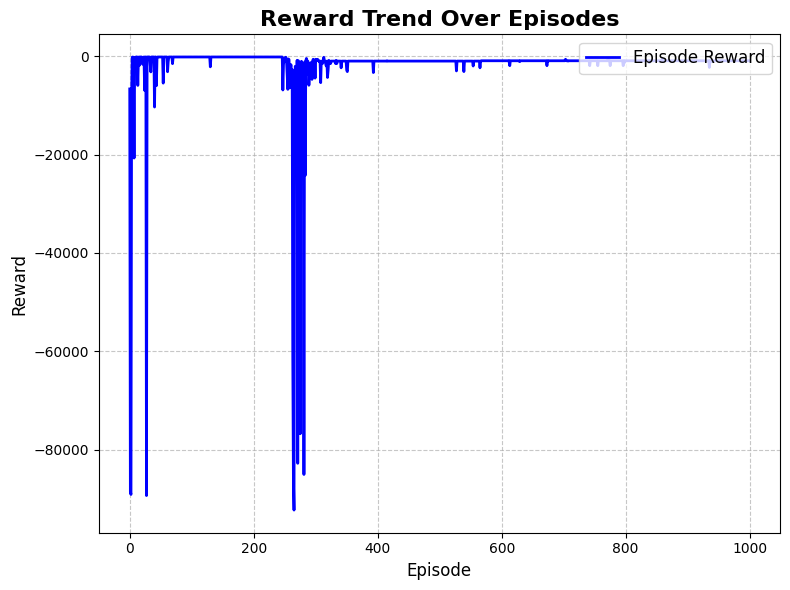

In [ ]:
def plot_graph_with_path(G, pos, path):
    """
    Plots the Sioux Falls network with charging stations and highlights the optimal path.

    Args:
        G (networkx.Graph): The graph object.
        pos (dict): A dictionary mapping node IDs to positions.
        path (list): The optimal path as a list of nodes.
    """
    plt.figure(figsize=(10, 10))

    # Define node colors (red for charging stations, blue otherwise)
    node_colors = ['red' if G.nodes[n].get('charging_station', False) else 'blue' for n in G.nodes]

    # Draw the graph with node labels
    nx.draw_networkx(G, pos=pos, with_labels=True, node_color=node_colors,
                     arrows=True, arrowsize=20, node_size=800,
                     font_color='white', font_size=14)

    # Draw edge labels (weights)
    edge_labels = {(u, v): f"{d['length']:.2f}" for u, v, d in G.edges(data=True) if 'length' in d}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    # Highlight the optimal path in red
    path_edges = list(zip(path[:-1], path[1:]))  # Extract edges from path
    nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color="green", width=3, alpha=0.8, label="Optimal Path")
    nx.draw_networkx_nodes(G, pos, nodelist=path, node_size=900, node_color="green", edgecolors="black")

    # Legend
    plt.scatter([], [], c='red', label='Charging Station', s=200)
    plt.scatter([], [], c='blue', label='Regular Node', s=200)
    plt.plot([], [], color="green", linewidth=3, label="Optimal Path")  # Line for path in legend
    plt.legend(loc='upper right', fontsize=12)

    # Title and layout
    plt.title('Sioux Falls Network with Optimal Path & Charging Stations', fontsize=14)
    plt.savefig('sioux-falls-network-optimal-path.png')
    plt.show()

# Function to plot the reward trend over episodes
def plot_reward_trend(episode_rewards):
    """
    Plots the reward trend over episodes.

    Args:
        episode_rewards (list): A list of rewards for each episode.
    """
    plt.figure(figsize=(8, 6))
    plt.plot(range(len(episode_rewards)), episode_rewards, label="Episode Reward", color="blue", linewidth=2)
    plt.xlabel("Episode", fontsize=12)
    plt.ylabel("Reward", fontsize=12)
    plt.title("Reward Trend Over Episodes", fontsize=16, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend(loc="upper right", fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function
plot_graph_with_path(G, pos, path)
# 2. Plot the reward trend over episodes
plot_reward_trend(episode_rewards)


##DQN

In [ ]:
import numpy as np
import random
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Define the DQN network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.9  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, valid_actions):
      if np.random.rand() <= self.epsilon:
          return random.choice(valid_actions)

      state = torch.FloatTensor(state)
      act_values = self.model(state)

      print(f"Valid actions: {valid_actions}")  # Debugging line
      print(f"Charging station index: {charging_station_index}")  # Debugging line

      valid_q_values = {}
      for action in valid_actions:
          if action not in charging_station_index:
              print(f"Warning: Action {action} not found in charging_station_index. Skipping.")
              continue
          valid_q_values[action] = act_values[charging_station_index[action]]

      if not valid_q_values:
          print("No valid actions found in charging_station_index. Choosing random action.")
          return random.choice(valid_actions)  # Fallback to avoid errors

      return max(valid_q_values, key=valid_q_values.get)

    def replay(self, batch_size):
      minibatch = random.sample(self.memory, batch_size)
      for state, action, reward, next_state, done in minibatch:
        state = torch.FloatTensor(state)
        next_state = torch.FloatTensor(next_state)
        target = reward
        if not done:
            target = (reward + self.gamma * torch.max(self.model(next_state)))
        target_f = self.model(state)

        # Debugging print statement
        print(f"Action: {action}, Available Keys: {charging_station_index.keys()}")

        if action not in charging_station_index:
            print(f"Warning: Action {action} not found in charging_station_index. Skipping update.")
            continue  # Skip update for this transition if key is missing

        target_f[charging_station_index[action]] = target
        self.optimizer.zero_grad()
        loss = self.criterion(self.model(state), target_f)
        loss.backward()
        self.optimizer.step()

      if self.epsilon > self.epsilon_min:
        self.epsilon *= self.epsilon_decay


# Function to convert node index to one-hot encoded state
def get_state(current_node, num_states):
    state = np.zeros(num_states)
    state[current_node - 1] = 1  # Convert to zero-based index
    return state

# Initialize the DQN agents for both layers
state_size = num_states
action_size_layer1 = num_actions
action_size_layer2 = len(charging_stations)
agent_layer1 = DQNAgent(state_size, action_size_layer1)
agent_layer2 = DQNAgent(state_size, action_size_layer2)

# Training the DQN agents
batch_size = 32
episode_rewards = []

for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = get_state(current_node, state_size)
        if SoC < 30:
            valid_actions = list(charging_stations)
            action = agent_layer2.choose_action(state, valid_actions)
            next_node, SoC, reward, time_taken = step_layer2(action, current_node, SoC, path)
            total_time += time_taken
            next_state = get_state(next_node, state_size)
            done = (next_node == destination_node)
            agent_layer2.remember(state, action, reward, next_state, done)
            episode_reward += reward
        else:
            valid_actions = list(G.neighbors(current_node))
            action = agent_layer1.choose_action(state, valid_actions)
            next_node, SoC, reward, time_taken = step_layer1(action, current_node, SoC, visited_nodes, path)
            total_time += time_taken
            next_state = get_state(next_node, state_size)
            done = (next_node == destination_node)
            agent_layer1.remember(state, action, reward, next_state, done)
            episode_reward += reward

        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

    if len(agent_layer1.memory) > batch_size:
        agent_layer1.replay(batch_size)
    if len(agent_layer2.memory) > batch_size:
        agent_layer2.replay(batch_size)

    episode_rewards.append(episode_reward)
    print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")

# Testing the trained model
current_node = 6
destination_node = 24
SoC = initial_SoC
path = [current_node]
total_time = 0
steps = 0
visited_nodes = set()
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = get_state(current_node, state_size)
    if SoC < 30:
        valid_actions = list(charging_stations)
        action = agent_layer2.choose_action(state, valid_actions)
        next_node, SoC, _, time_taken = step_layer2(action, current_node, SoC, path)
        total_time += time_taken
        charging_stations_visited[action] = time_taken
    else:
        valid_actions = list(G.neighbors(current_node))
        action = agent_layer1.choose_action(state, valid_actions)
        next_node, SoC, _, time_taken = step_layer1(action, current_node, SoC, visited_nodes, path)
        total_time += time_taken

    if next_node == current_node:
        total_time += 10

    if not (path and path[-1] == next_node):
        path.append(next_node)

    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
if charging_stations_visited:
    print("Charging Stations Visited and Time Spent:")
    for station, time_spent in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes")
else:
    print("No Charging Stations Visited.")

Streaming output truncated to the last 5000 lines.
No valid actions found in charging_station_index. Choosing random action.
Valid actions: [3, 5, 11]
Charging station index: {16: 0, 2: 1, 12: 2, 6: 3}
No valid actions found in charging_station_index. Choosing random action.
Valid actions: [16, 2, 12, 6]
Charging station index: {16: 0, 2: 1, 12: 2, 6: 3}
Valid actions: [3, 11, 13]
Charging station index: {16: 0, 2: 1, 12: 2, 6: 3}
No valid actions found in charging_station_index. Choosing random action.
Valid actions: [12, 24]
Charging station index: {16: 0, 2: 1, 12: 2, 6: 3}
Valid actions: [3, 11, 13]
Charging station index: {16: 0, 2: 1, 12: 2, 6: 3}
No valid actions found in charging_station_index. Choosing random action.
Valid actions: [12, 24]
Charging station index: {16: 0, 2: 1, 12: 2, 6: 3}
Valid actions: [3, 11, 13]
Charging station index: {16: 0, 2: 1, 12: 2, 6: 3}
No valid actions found in charging_station_index. Choosing random action.
Valid actions: [4, 10, 12, 14]
Chargi

In [ ]:
import numpy as np
import random
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Define the DQN network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Define the DQN agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.9  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state, valid_actions, visited_nodes):
        if np.random.rand() <= self.epsilon:
            filtered_actions = [a for a in valid_actions if a not in visited_nodes]
            return random.choice(filtered_actions) if filtered_actions else random.choice(valid_actions)

        state = torch.FloatTensor(state)
        act_values = self.model(state).detach().numpy()

        # Filter valid actions within model's action space
        valid_q_values = {action: act_values[action] for action in valid_actions if action < len(act_values)}

        if not valid_q_values:
            return random.choice(valid_actions)  # Fallback if no valid actions exist

        return max(valid_q_values, key=valid_q_values.get)

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state)
            next_state = torch.FloatTensor(next_state)
            target = reward
            if not done:
                target = (reward + self.gamma * torch.max(self.model(next_state)))
            target_f = self.model(state).clone().detach()

            if action < len(target_f):
                target_f[action] = target

            self.optimizer.zero_grad()
            loss = self.criterion(self.model(state), target_f)
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


# Function to convert node index to one-hot encoded state
def get_state(current_node, num_states):
    state = np.zeros(num_states)
    state[current_node - 1] = 1  # Convert to zero-based index
    return state

# Initialize the DQN agents for both layers
state_size = num_states
action_size_layer1 = num_actions
action_size_layer2 = len(charging_stations)
agent_layer1 = DQNAgent(state_size, action_size_layer1)
agent_layer2 = DQNAgent(state_size, action_size_layer2)

# Training the DQN agents
batch_size = 32
episode_rewards = []

for episode in range(num_episodes):
    current_node = 1
    SoC = initial_SoC
    total_time = 0
    steps = 0
    visited_nodes = set()
    episode_reward = 0
    path = [current_node]

    while current_node != destination_node and steps < max_steps_per_episode:
        state = get_state(current_node, state_size)

        if SoC < 30:
            valid_actions = list(charging_stations)
            action = agent_layer2.choose_action(state, valid_actions, visited_nodes)
            next_node, SoC, reward, time_taken = step_layer2(action, current_node, SoC, path)
        else:
            valid_actions = list(G.neighbors(current_node))
            action = agent_layer1.choose_action(state, valid_actions, visited_nodes)
            next_node, SoC, reward, time_taken = step_layer1(action, current_node, SoC, visited_nodes, path)

        # Check if the node has been visited before (loop detection)
        if next_node in visited_nodes:
            reward -= 1000  # Heavy penalty for revisiting the same node

        total_time += time_taken
        next_state = get_state(next_node, state_size)
        done = (next_node == destination_node)

        agent_layer1.remember(state, action, reward, next_state, done) if SoC >= 30 else agent_layer2.remember(state, action, reward, next_state, done)
        episode_reward += reward

        visited_nodes.add(current_node)
        current_node = next_node
        steps += 1

    if len(agent_layer1.memory) > batch_size:
        agent_layer1.replay(batch_size)
    if len(agent_layer2.memory) > batch_size:
        agent_layer2.replay(batch_size)

    episode_rewards.append(episode_reward)
    print(f"Episode: {episode}, Total Time: {total_time}, Episode Reward: {episode_reward}")

# Testing the trained model
current_node = 6
destination_node = 24
SoC = initial_SoC
path = [current_node]
total_time = 0
steps = 0
visited_nodes = set()
charging_stations_visited = {}

while current_node != destination_node and steps < max_steps_per_episode:
    state = get_state(current_node, state_size)

    if SoC < 30:
        valid_actions = list(charging_stations)
        action = agent_layer2.choose_action(state, valid_actions, visited_nodes)
        next_node, SoC, _, time_taken = step_layer2(action, current_node, SoC, path)
        total_time += time_taken
        charging_stations_visited[action] = time_taken
    else:
        valid_actions = list(G.neighbors(current_node))
        action = agent_layer1.choose_action(state, valid_actions, visited_nodes)
        next_node, SoC, _, time_taken = step_layer1(action, current_node, SoC, visited_nodes, path)
        total_time += time_taken

    # Apply penalty for revisiting nodes
    if next_node in visited_nodes:
        total_time += 10  # Additional time penalty

    if not (path and path[-1] == next_node):
        path.append(next_node)

    visited_nodes.add(current_node)
    current_node = next_node
    steps += 1

print("Optimal Path:", path)
print("Total Time to Reach Destination:", total_time, "minutes")
if charging_stations_visited:
    print("Charging Stations Visited and Time Spent:")
    for station, time_spent in charging_stations_visited.items():
        print(f"Charging Station {station}: {time_spent} minutes")
else:
    print("No Charging Stations Visited.")


Episode: 0, Total Time: 366.6666666666667, Episode Reward: -431.6666666666667
Episode: 1, Total Time: 281.6666666666667, Episode Reward: -185322.1666666667
Episode: 2, Total Time: 295.0, Episode Reward: -182345.5
Episode: 3, Total Time: 525.0, Episode Reward: -169592.0
Episode: 4, Total Time: 295.0, Episode Reward: -182343.0
Episode: 5, Total Time: 209.99999999999997, Episode Reward: -1230.0
Episode: 6, Total Time: 93.33333333333333, Episode Reward: -193107.3333333333
Episode: 7, Total Time: 93.33333333333333, Episode Reward: -193107.3333333333
Episode: 8, Total Time: 73.33333333333333, Episode Reward: -193084.3333333333
Episode: 9, Total Time: 281.6666666666667, Episode Reward: -183332.1666666667
Episode: 10, Total Time: 93.33333333333333, Episode Reward: -193107.3333333333
Episode: 11, Total Time: 270.0, Episode Reward: -179345.0
Episode: 12, Total Time: 93.33333333333333, Episode Reward: -193107.3333333333
Episode: 13, Total Time: 270.0, Episode Reward: -186318.5
Episode: 14, Total 